# Accessing variable and transient objects in the truth catalog

**Notebook owner**: Yao-Yuan Mao [@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao).

**Last Run:** 2019-02-23

In addition to transients being included in images, information on the magnitudes of the transients are included in truth catalogs (input to the image simulation), which can eventually be compared to e.g., the fluxes determined from a difference image. This tutorial shows how to access the truth tables for these transients, and how to search for transients based on properties like magnitude or RA, Dec position.

**Learning Objectives:** Use GCR to load summary table and light curves of variable and transient objects in the truth catalogs

**Notes:** 
- Variable and transient objects are **not** available in truth catalog 1.1
- To run this notebook, follow the instructions to setup Jupyter-dev at NERSC: https://confluence.slac.stanford.edu/x/1_ubDQ

In [1]:
# import packages and methods that will be used in this notebook

import healpy as hp
import numpy as np
import GCRCatalogs
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Summary catalog

First, we'll load the **summary catalog** (`sc`). The summary catalog is just a simple table that contains the coordinates, types, and id of the objects. 

The `filters` and `native_filters` options work just like how they work for the static object catalog (see the `truth_gcr_intro` tutorial notebook). 

In [2]:
sc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')
sc.list_all_quantities(include_native=True)

['sprinkled', 'uniqueId', 'sn', 'agn', 'redshift', 'galaxy_id', 'ra', 'dec']

Let's now plot the locations of supernova and AGNs on the sky

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_truth.py:72: UserWarning: For this particular truth catalog, `native_filters` is no longer supported.
Please use `filters` instead. For now this code will include your `native_filters` in `filters`.
(Note that `native_filters` still works for other GCR catalogs.)
  warnings.warn('For this particular truth catalog, `native_filters` is no longer supported.\n'


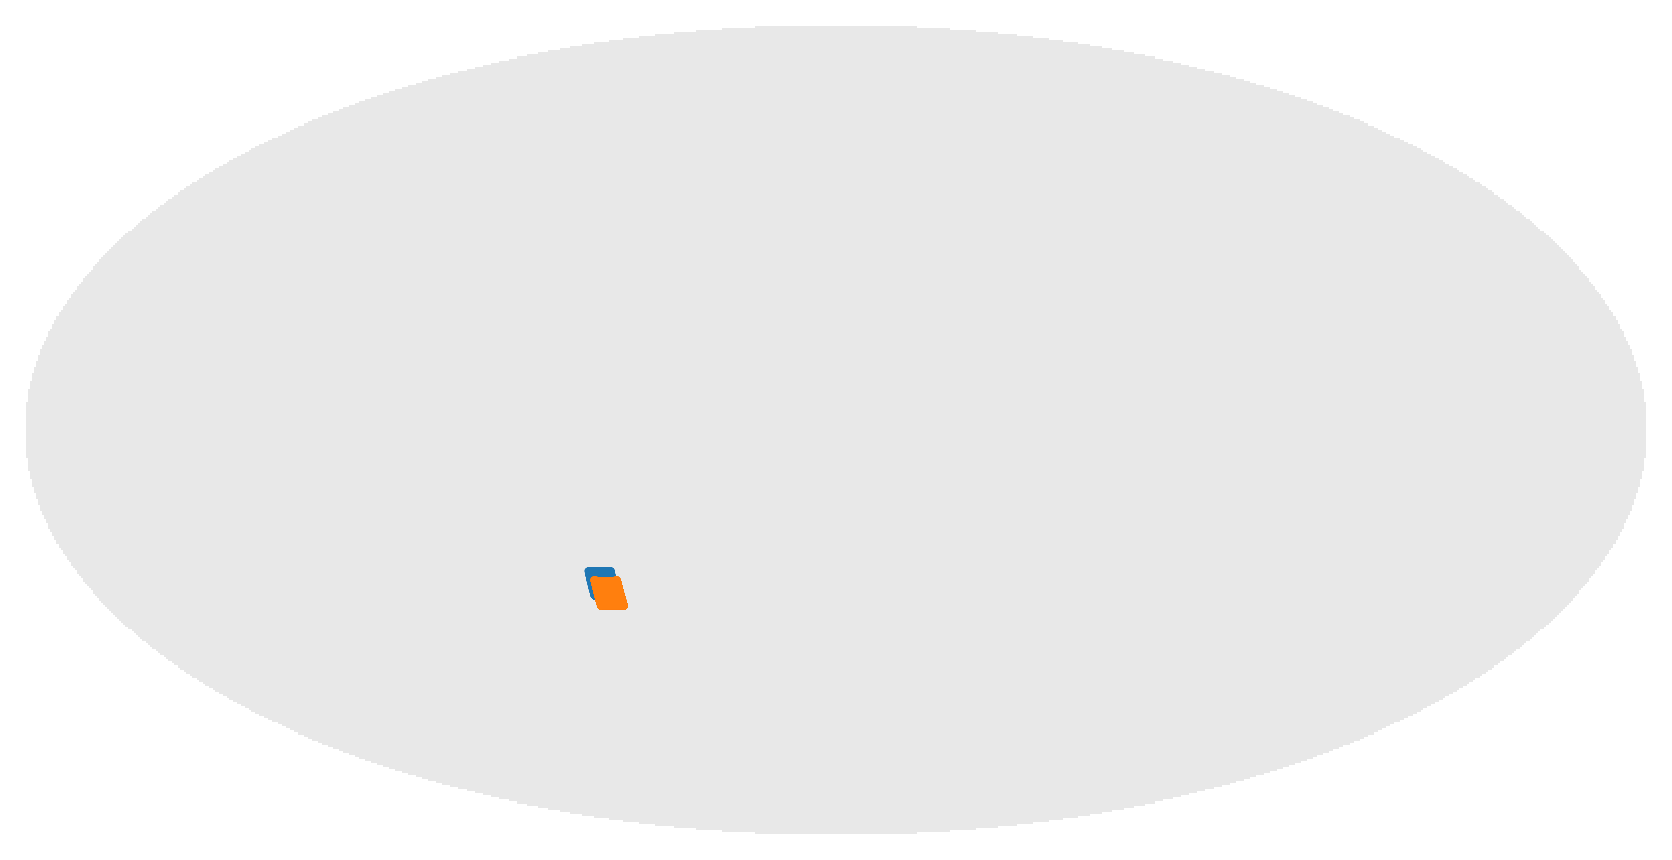

In [3]:
hp.mollview(np.ones(hp.nside2npix(2)), title='', cmap='Greys', min=0.9, max=1.5, cbar=None) # to get an empty sky map

data = sc.get_quantities(['ra', 'dec'], native_filters=['sn == 1'])
hp.projscatter(data['ra'], data['dec'], lonlat=True, s=1)

data = sc.get_quantities(['ra', 'dec'], native_filters=['agn == 1'])
hp.projscatter(data['ra'], data['dec'], lonlat=True, s=1)

## light curve catalog

The way to access light curve catalog (`lc`) is a bit different.

The data returned by the reader are the light curve tables, which have 5 columns: `uniqueId`, `obshistid`, `mjd`, `filter`, `mag`; and the `filters` option would work on any of these columns.

However, the `native_filters` option works differently. They would be imposed on the columns of the "summary catalog" we mentioned above, so that one can for example select SNs from a certain RA ranges. 

Another difference is that, when `return_iterator` is turned on, the reader will iterator over the objects (i.e., returns one light curve table per objects). 

It's probably easier to illustrate this by an example.

In [4]:
lc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')
lc.list_all_quantities(include_native=True)

['filter', 'uniqueId', 'obshistid', 'mjd', 'mag']

Let's plot the i-band light curves for 3 supernovae. 

Note that here `filter` can be an integer of 0 to 5, and they correspond to `ugrizy` filters respectively.

Text(0, 0.5, '$i$ [mag]')

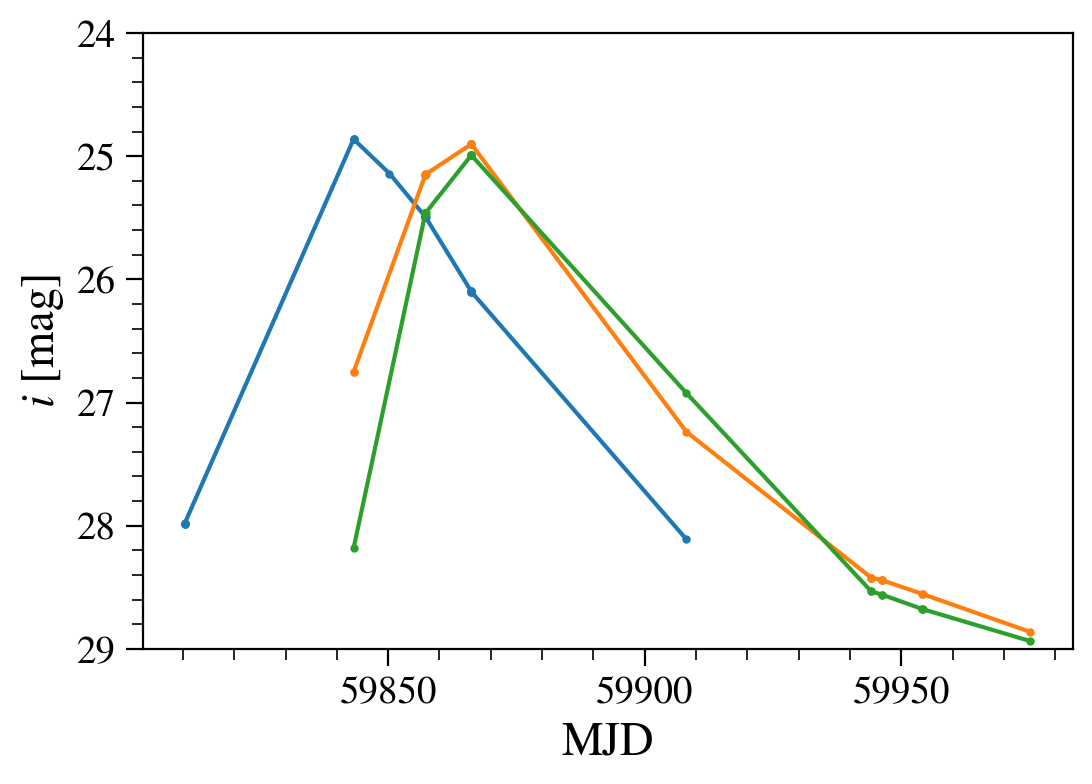

In [5]:
n_plotted = 0
for q in lc.get_quantities(['mjd', 'mag'], filters=['filter == 3'], native_filters=['sn == 1'], return_iterator=True):
    if len(q['mjd']) >= 20:
        plt.plot(q['mjd'], q['mag'], '.-')
        n_plotted += 1
    if n_plotted >= 3:
        break
plt.ylim(29, 24)
plt.xlabel('MJD')
plt.ylabel('$i$ [mag]')

### Example 1: getting RA and Dec of all SNe whose brightest magnitude is brighter than a certain value

In this example, you will need to first iterate over the objects in the light curve table. 
You can do that by setting `return_iterator=True`. 
For each object, you then find the brightest r-band magnitude in the light curve, and see if it satisfies your criteria. 
If so, then you record the object ID (`uniqueId`), which you then use to get RA, Dec from summery table later. 

In [6]:
lc_data = []
for q in lc.get_quantities(['uniqueId', 'mag'], filters=['filter == 2'], native_filters=['sn == 1'], return_iterator=True):
    if len(q['mag']) and q['mag'].min() < 25.5:
        lc_data.append((q['uniqueId'][0], q['mag'].min()))
lc_data = np.array(lc_data, dtype=np.dtype([('uniqueId', int), ('mag_brightest', float)]))

In [7]:
data = sc.get_quantities(['uniqueId', 'ra', 'dec'], filters=[(lambda x: np.in1d(x, lc_data['uniqueId'], True), 'uniqueId')])

In [8]:
# let's check if all the IDs actually match
# Food for thought: is this always true? What if the order is not preserved between the two tables?

(data['uniqueId'] == lc_data['uniqueId']).all()

False

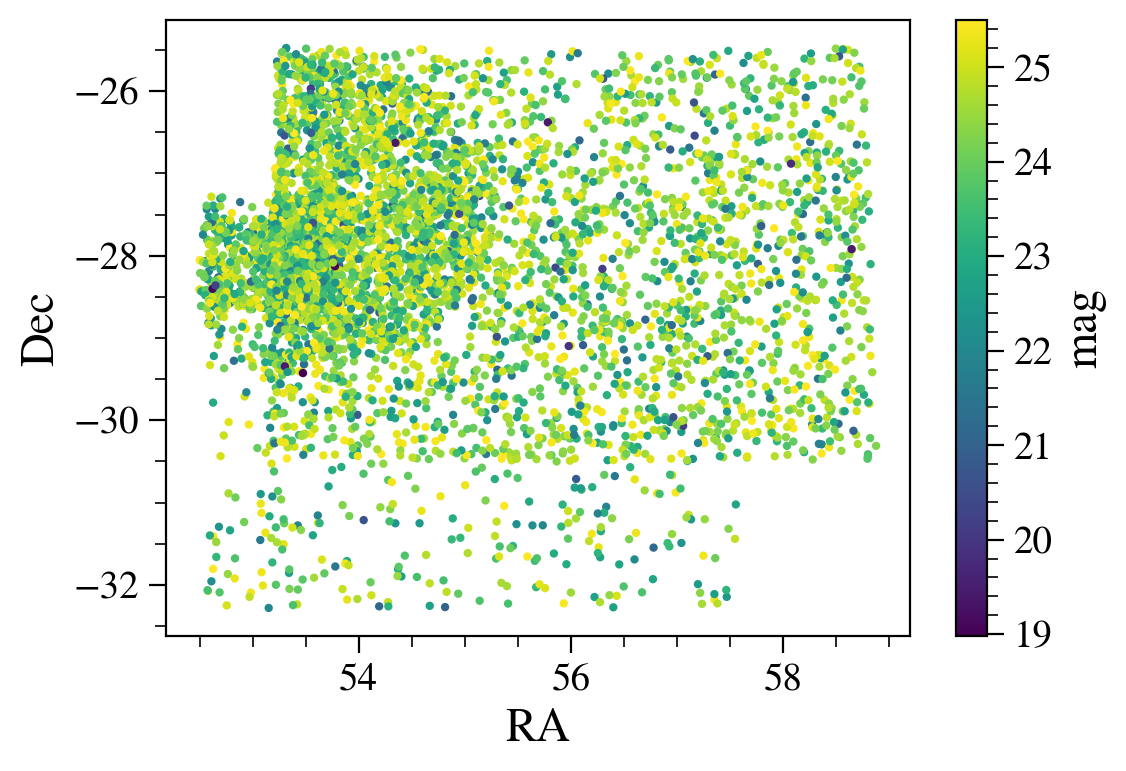

In [9]:
plt.scatter(data['ra'], data['dec'], c=lc_data['mag_brightest'], s=4);
plt.xlabel('RA');
plt.ylabel('Dec');
plt.colorbar(label='mag');

# Food for thought: there seem to be different densities in different areas. Why?

### Example 2: a histogram of brighest mag for all SNe in a particular area

This is an "opposite" task of Example 1. Here, we want to plot a histogram of brighest mag for all SNe in a particular area. 

When querying the light curve table, you can use `native_filters` to filter on the columns of the summary table. 
Hence, for this task, you **only** need to use the light curve table (surprise!)

In [10]:
area_cut = ['ra > 58', 'dec > -30', 'dec < -28']
sn_cut = ['sn == 1']
all_cuts = area_cut + sn_cut

mags = []
for q in lc.get_quantities(['mag'], filters=['filter == 1'], native_filters=all_cuts, return_iterator=True):
    if len(q['mag']):
        mags.append(q['mag'].min())

mags = np.array(mags)

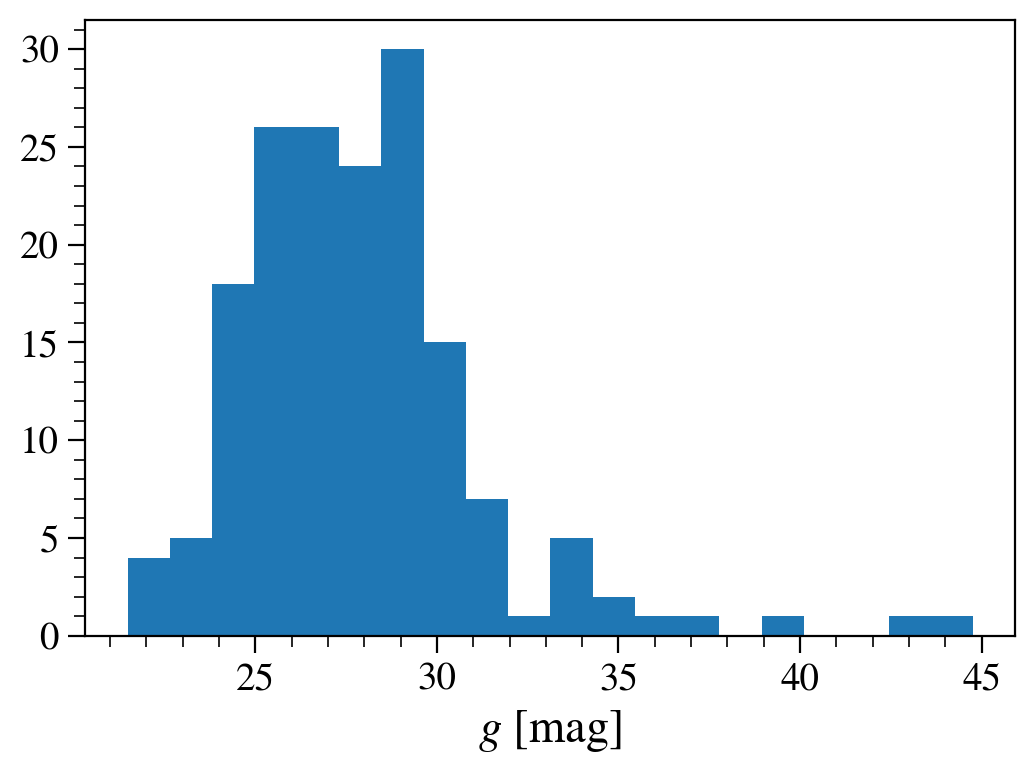

In [11]:
plt.hist(mags, 20);
plt.xlabel('$g$ [mag]');